In [1]:
SALIENCY_DIR = '/data/amartyadutta/sensitivity_exp/'
MODEL_FLAG = 'original' # 'noisy'
INPUT_FMT = 'crop_accumulate' # 'crop', 'mask', 'crop_mask'
NUM_CROPS = 200
size= 224
NUM_MASKS = 50
# if INPUT_FMT == 'crop_mask':
#     NUM_MASKS = 20
# else:
#     NUM_MASKS = 50

# SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image_crop/'
# SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image_binmask/'
# SALIENCY_DIR = '/raid/maruf/WSS/SALIENCY/original/image_binmask_crop/'

In [2]:
from __future__ import print_function
import os
import sys
sys.path.append('../../')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import numpy as np
import torch
import torch.optim
from torch.autograd import Variable
from torch import multiprocessing, cuda
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
from torch.backends import cudnn
import seaborn as sns
import importlib
import os
from tqdm import tqdm
import voc12.dataloader
from misc import torchutils, imutils, myutils
import torchvision.transforms as transforms
from misc.myutils import unnormalize_image

In [3]:
GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3,4,5'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 6


In [4]:
CLASSNAME_LIST = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train',
        'tvmonitor']

# Load Dataset

In [5]:
from chainercv.datasets import VOCSemanticSegmentationDataset
from chainercv.evaluations import calc_semantic_segmentation_confusion

# ground truth labels in gt_labels

gt_dataset = VOCSemanticSegmentationDataset(split="train",
                                            data_dir='/home/amartyadutta/VOC12/AMN/Datasets/VOCdevkit/VOC2012')

gt_labels = [gt_dataset.get_example_by_keys(i, (1,))[0] for i in range(len(gt_dataset))]


# segmentation dataset and data_loader 

dataset = voc12.dataloader.VOC12ClassificationDatasetMSF(img_name_list_path='/home/amartyadutta/VOC12/AMN/voc12/train.txt',
                                                         voc12_root='/home/amartyadutta/VOC12/AMN/Datasets/VOCdevkit/VOC2012', 
                                                         scales=(1.0,))

data_loader = DataLoader(dataset, shuffle=False)


# NDR gt corresponds to non-deterministic region ground truths

ndr_gt_labels = [np.load(os.path.join('/raid/maruf/WSS/NDR_ground_truth', id + '.npy'), allow_pickle=True) for id in gt_dataset.ids]


# Load Model

In [6]:
model = getattr(importlib.import_module('net.resnet50_cam'), 'CAM_original')()

if MODEL_FLAG == 'original':
    model.load_state_dict(torch.load('/home/maruf/ws2m2/sess/res50_cam_original_version.pth' + '.pth', map_location='cpu'), strict=True)

elif MODEL_FLAG == 'noisy':
    model.load_state_dict(torch.load('/home/maruf/ws2m2/sess/res50_cam_bin_noise_version.pth' + '.pth', map_location='cpu'), strict=True)
    
model.eval()

model = model.cuda()

# SALIENCY

In [7]:
from torch.utils.data import Dataset

class RandomCropDataset(Dataset):
    def __init__(self, tensor, transform, size=1):
        self.tensor = tensor.squeeze(0)
        self.transform = transform
        self.size = size
    
    def __len__(self):
        return self.size
    
    def __getitem__(self, idx):
        return self.transform(self.tensor)

    
def get_saliencies(
    img_tensor,
    target_class,
    transform,
    input_fmt='img',
    num_crops=200,
    num_masks = 50
):
    
    
    
    if input_fmt == 'img':
        
        model.zero_grad()
        
        img_tensor.requires_grad = True

        scores = model(img_tensor.type(dtype))

        combined_saliencies = []

        for class_idx in target_class:

            target_score = scores[:, class_idx]

            saliency = torch.autograd.grad(
                target_score, img_tensor,
                grad_outputs = torch.ones_like(target_score),
                retain_graph = True
            )[0]

            saliency = saliency.detach().abs().max(1)[0]
            combined_saliencies.append(saliency)

        raw_saliency = torch.cat(combined_saliencies).detach()
        
        return raw_saliency
    
    elif input_fmt == 'crop_accumulate':
        
        img_tensor.requires_grad = True
        
        dataset = RandomCropDataset(img_tensor, transform, size=num_crops)
        dataloader = DataLoader(dataset, batch_size=100)

        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        real_saliencies = torch.zeros(num_classes, 1, H, W).type(dtype)
        for batch in dataloader:
            model.zero_grad()
            out = model(batch.type(dtype))
    
            for i, label in enumerate(target_class):
                label = label.long()
                target_val = out[:,label]
                weights = torch.sigmoid(target_val)

                # Weighted Saliency
                saliency = torch.autograd.grad(
                                        target_val, img_tensor, 
                                        grad_outputs=weights,
                                        retain_graph=True
                                    )[0]
                saliency = saliency.detach().abs().max(1)[0]
                real_saliencies[i] += saliency.type(dtype)

        raw_saliency = real_saliencies.squeeze(1).detach()
        
        return raw_saliency
        
        
    elif input_fmt == 'mask':
        
        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        agg_saliencies = torch.zeros(num_classes, H, W).type(dtype)
        
        for _ in range(num_masks):
            
            prob_mask = 0.9 * torch.ones(H, W)
            binary_mask = torch.bernoulli(prob_mask).detach()
            binary_mask.requires_grad = True
            
            noisy_img = img_tensor * binary_mask
            
            model.zero_grad()

            scores = model(noisy_img.type(dtype))

            combined_saliencies = []

            for class_idx in target_class:

                target_score = scores[:, class_idx]

                saliency = torch.autograd.grad(
                    target_score, binary_mask,
                    grad_outputs = torch.ones_like(target_score),
                    retain_graph = True
                )[0]

                saliency = saliency.detach().abs()
                
                combined_saliencies.append(saliency.unsqueeze(0))
                
            raw_saliency = torch.cat(combined_saliencies)
            
            agg_saliencies += raw_saliency.type(dtype)
            
        agg_saliencies /= num_masks
        
        return agg_saliencies
    
    elif input_fmt == 'crop_mask':
        
        _, _, H, W = img_tensor.shape
        num_classes = len(target_class)
        agg_saliencies = torch.zeros(num_classes, H, W).type(dtype)
        
        for _ in range(num_masks):
            
            prob_mask = 0.9 * torch.ones(H, W)
            binary_mask = torch.bernoulli(prob_mask).detach()
            binary_mask.requires_grad = True
            
            noisy_img = img_tensor * binary_mask
            
            #####
            dataset = RandomCropDataset(noisy_img, transform, size=num_crops)
            dataloader = DataLoader(dataset, batch_size=100)

            # _, _, H, W = img_tensor.shape
            # num_classes = len(target_class)
            real_saliencies = torch.zeros(num_classes, H, W).type(dtype)

            for batch in dataloader:
                model.zero_grad()
                out = model(batch.type(dtype))
                for i, label in enumerate(target_class):
                    label = label.long()
                    target_val = out[:,label]
                    weights = torch.sigmoid(target_val)
                    saliency = torch.autograd.grad(
                                            target_val, binary_mask, 
                                            grad_outputs=weights,
                                            retain_graph=True
                                        )[0]
                    saliency = saliency.detach().abs()
                    
                    real_saliencies[i] += saliency.type(dtype)

            raw_saliency = real_saliencies.detach()
            #####
            
            agg_saliencies += raw_saliency.type(dtype)
                    
        agg_saliencies /= num_masks
        
        return agg_saliencies
            

# Save Saliencies

In [8]:
# for iter, pack in enumerate(tqdm(data_loader)):
        
#     img_name = pack['name'][0]
    
#     if os.path.exists(os.path.join(SALIENCY_DIR, img_name+'.npy')):
#         continue

#     label = pack['label'][0]
    
#     target_class = torch.nonzero(label)[:, 0]
    
#     input_img = pack['img'][0][0:1, ...]
    
#     with torch.autocast(device_type = 'cuda', dtype = torch.float16):
#         saliency = get_saliencies(img_tensor=input_img,
#                                   target_class=target_class,
#                                   input_fmt=INPUT_FMT,
#                                   num_masks=NUM_MASKS)

#         np.save(os.path.join(SALIENCY_DIR, img_name+'.npy'), 
#                     {'saliency': saliency.cpu().numpy(), 'cls_label': target_class})


# Processing Functions

In [9]:
def smooth(input_saliency):
    '''
    tensor -> tensor
    input_saliency.shape = Num_class, H, W
    output_saliency.shape = Num_class, H, W
    
    '''
    
    input_saliency = input_saliency.unsqueeze(1)
    
    kernel_size, sigma = 13, 5
    
    axis = torch.linspace(-(kernel_size-1)/2., 
                          -(kernel_size-1)/2., 
                          kernel_size)
    gaussian = torch.exp(- 0.5 * axis**2 / sigma**2)
    
    kernel = torch.outer(gaussian, gaussian)[None, None, :, :]
    
    output_saliency = F.conv2d(input_saliency, kernel, padding=kernel_size//2)
    
    return output_saliency.squeeze(1)


In [10]:
def normalization(input_saliency):
    '''
    tensor -> tensor
    input_saliency.shape = Num_class, H, W
    output_saliency.shape = Num_class, H, W
    
    '''
    N_CLASS, H, W = input_saliency.shape
    
    input_saliency = input_saliency.unsqueeze(1)
    
    min_ = input_saliency.view(N_CLASS, -1).min(-1)[0]
    min_ = min_[:, None, None, None].repeat(1, 1, H, W)
    
    max_ = torch.quantile(input = input_saliency.view(N_CLASS,-1), 
                          q = 0.995, 
                          dim=-1, keepdim=False, 
                          interpolation="nearest", out=None)
    max_ = max_[:, None, None, None].repeat(1, 1, H, W)
    
    saliency = torch.clamp(input_saliency, max=max_)
    saliency_normalized = (saliency - min_)/(max_ - min_)
    
    return saliency_normalized.squeeze(1)

In [11]:
def subtraction(input_saliency, weights=[1.5, 0.5]):
    '''
    tensor -> tensor
    input_saliency.shape = Num_class, H, W
    output_saliency.shape = Num_class, H, W
    
    '''
    N_CLASS, H, W = input_saliency.shape
    
    input_saliency = input_saliency.unsqueeze(1)
    
    sub_tensor = -1*weights[1]*torch.ones(N_CLASS, N_CLASS) + weights[0]*torch.eye(N_CLASS)
    
    out_saliency = F.relu(torch.einsum("ij,jklm->iklm",
                                       sub_tensor, 
                                       input_saliency))
    return out_saliency.squeeze(1)

In [12]:
def resolve_background(input_saliency, cls_label, thres=0.3):
    '''
    tensor -> ndarray
    input_saliency.shape = Num_class, H, W
    cls_label = sal_obj['cls_label']
    predicted_saliency.shape = H, W
    '''
    
    saliency = subtraction(input_saliency)
    saliency_ndarray = normalization(saliency).cpu().numpy()
    
    saliency_bg = np.pad(saliency_ndarray, 
                  ((1, 0), (0, 0), (0, 0)), 
                  mode='constant', 
                  constant_values=thres)
    
    keys = np.pad(cls_label + 1, 
                  (1, 0), 
                  mode='constant')
    
    cls_labels = np.argmax(saliency_bg, axis=0)
        
    predicted_saliency = keys[cls_labels]
    
    return predicted_saliency

In [13]:
def super_pixel_prediction(input_saliency, img_name, thres=0.1, fmt='absolute'):
    '''
    tensor -> ndarray
    input_saliency.shape = Num_class, H, W
    predicted_class.shape = H, W
    '''
    saliency_ndarray = input_saliency.cpu().numpy()
    
    N_CLASS, H, W = input_saliency.shape
    
    sp_onehot_mask = np.load(f"/data/voc12/superpixel/masks/{img_name}.npy")
    
    predicted_mask = [np.zeros_like(saliency_ndarray[0])+1e-8]
    
    for idx in range(N_CLASS):
        
        saliency = saliency_ndarray[idx]
        scattered_saliency = sp_onehot_mask * saliency[None, :, :]
        sp_score = scattered_saliency.sum((1, 2))/sp_onehot_mask.sum((1, 2))
        
        if fmt=='absolute':
            selected_mask = sp_score > thres
            
        else:
            selected_mask = sp_score > (thres * sp_score.mean())
            
        aggregated_saliency = scattered_saliency[selected_mask].sum(0)
        
        predicted_mask.append(aggregated_saliency)
        
    predicted_class = np.stack(predicted_mask).argmax(0)
    
    return predicted_class
            

In [14]:
def get_predictions(saliency, class_label, thres=0.25, smoothing=False, superpixel=False):
    
        
    keys = np.pad(class_label + 1, 
                  (1, 0), 
                  mode='constant')


    if smoothing:

        saliency_tensor = smooth(saliency)

        saliency_tensor = normalization(saliency)

    if superpixel:

        saliency_tensor = subtraction(saliency)

        saliency_tensor = normalization(saliency)

        cls_labels = super_pixel_prediction(saliency, 
                                            img_name, 
                                            thres=thres, 
                                            fmt='absolute')
        cls_labels = keys[cls_labels]

        preds.append(cls_labels.copy())

    else:
        cls_labels = resolve_background(saliency, 
                                        class_label, 
                                        thres=thres)
        return cls_labels.copy()
        


In [15]:
def viz_first_n_saliencies(options, n=1, thres=0.25):
    
    for iter, pack in enumerate(data_loader):
        
        img_name = pack['name'][0]
        
        input_img = pack['img'][0][0:1, ...]
        
        sal_obj = np.load(os.path.join(SALIENCY_DIR, img_name + '.npy'), allow_pickle=True).item()
        
        saliency = sal_obj['saliency']
    
        cls_label = sal_obj['cls_label']
        
        keys = np.pad(cls_label + 1, 
                      (1, 0), 
                      mode='constant')
        
        saliency_tensor = torch.tensor(saliency)
        
        preds = []
        
        if options['smoothing']:
            
            saliency_tensor = smooth(saliency_tensor)
            
            saliency_tensor = normalization(saliency_tensor)
            
        if options['superpixel']:
            
            saliency_tensor = subtraction(saliency_tensor)
            
            saliency_tensor = normalization(saliency_tensor)
            
            cls_labels = super_pixel_prediction(saliency_tensor, 
                                                img_name, 
                                                thres=thres, 
                                                fmt='absolute')
            cls_labels = keys[cls_labels]
            
            preds.append(cls_labels.copy())
            
        else:
            cls_labels = resolve_background(saliency_tensor, 
                                            cls_label, 
                                            thres=thres)
            preds.append(cls_labels.copy())
        
        
        predicted_saliency = preds[0]
        gt_label = gt_labels[iter]
        ndr_gt_label = ndr_gt_labels[iter]
        
        fig, ax = plt.subplots(1, 3, figsize=(12, 3))
        ax[0].imshow(myutils.unnormalize_image(input_img))
        ax[0].axis('off')
        ax[0].set_title('iou:{:.2f}\nNDR-iou:{:.2f}'.format(compute_miou([predicted_saliency], [gt_label]), compute_miou([predicted_saliency], [ndr_gt_label])))
        sns.heatmap(gt_label, vmax='20', cmap='tab20', ax=ax[1])
        ax[1].axis('off')
        ax[1].set_title('Ground Truth')
        sns.heatmap(predicted_saliency, vmax='20', cmap='tab20', ax=ax[2])
        ax[2].axis('off')
        ax[2].set_title('Saliency prediction')
        # plt.savefig('vis_'+str(count)+'.png')
        plt.show()
        
        if iter+1 == n:
            break
        
   

## miou functions

In [16]:
from chainercv.evaluations import calc_semantic_segmentation_confusion

def compute_miou(preds, gts):
    
    confusion = calc_semantic_segmentation_confusion(preds, gts)

    gtj = confusion.sum(axis=1)
    resj = confusion.sum(axis=0)
    gtjresj = np.diag(confusion)
    denominator = gtj + resj - gtjresj
    iou = gtjresj / denominator

    return np.nanmean(iou)

## Generating Saliencies and Calculating mIOU

In [17]:
pos_crops = [100,150,200]

In [18]:
scale_set = [ 0.05, 0.1, 0.15, 0.2, 0.3]

In [19]:
thres = 0.1

In [20]:
for n_crop in pos_crops:

    for i in range(len(scale_set)-1):
        
        scale1 = scale_set[i]
        
        for c in range(1, len(scale_set)- i):
            
            scale2 = scale_set[i+c]
            

            t = transforms.Compose([
            transforms.RandomResizedCrop(
                (224,224),
                scale=(scale1, scale2), 
                ratio=(1, 1)
            )
            ])
            
            predictions = []
            print("Generating Saliencies")
            
            for iter, pack in enumerate(tqdm(data_loader)):
                    img_name = pack['name'][0]


                    label = pack['label'][0]

                    target_class = torch.nonzero(label)[:, 0]
                    number_classes = int(label.sum().item())

                    input_img = pack['img'][0][0:1, ...]

                    gt_label = gt_labels[iter]

                    with torch.autocast(device_type = 'cuda', dtype = torch.float16):
                        
                        
                        
                        accumulated_saliency = get_saliencies(img_tensor=input_img,
                                                  target_class=target_class, transform = t,
                                                  input_fmt='crop_accumulate',num_crops=n_crop,
                                                  num_masks=NUM_MASKS)
                        
                        #Saving salienices
                        np.save(os.path.join(SALIENCY_DIR, img_name+"_"+str(n_crop)+"_"+str(scale1)+"_"+str(scale2)+'.npy'),
                                {'saliency': accumulated_saliency.cpu().numpy(), 'cls_label': target_class})
                    
    
                        preds = get_predictions(accumulated_saliency.cpu(),target_class, thres=thres, smoothing=False, superpixel=False)
                        predictions.append(preds)
                        
                        
            print("Calculating miou")
            print(f'\n{"".join(["#" for i in range(60)])}')
            print('SMOOTHING: False, SUPERPIXEL: False')
            print(f'{"".join(["#" for i in range(60)])}\n')
            
        
            miou = compute_miou(predictions, gt_labels)
            ndr_miou = compute_miou(predictions, ndr_gt_labels)
            print('{:.0f} Crops, Scale values: {:.2f} - {:.2f}'.format(n_crop, scale1, scale2))
            print(f'\nmIoU for {thres}: {miou}\nNDR-mIoU for {thres}: {ndr_miou}\n\n')
                        
                    
    


Generating Saliencies


100%|██████████| 1464/1464 [19:42<00:00,  1.24it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

100 Crops, Scale values: 0.05 - 0.10

mIoU for 0.1: 0.3897053468272321
NDR-mIoU for 0.1: 0.31365367140343414


Generating Saliencies


100%|██████████| 1464/1464 [19:44<00:00,  1.24it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

100 Crops, Scale values: 0.05 - 0.15

mIoU for 0.1: 0.39677079946092536
NDR-mIoU for 0.1: 0.3340198776072462


Generating Saliencies


100%|██████████| 1464/1464 [17:23<00:00,  1.40it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

100 Crops, Scale values: 0.05 - 0.20

mIoU for 0.1: 0.3978762051085771
NDR-mIoU for 0.1: 0.3442692825226056


Generating Saliencies


100%|██████████| 1464/1464 [14:55<00:00,  1.64it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

100 Crops, Scale values: 0.05 - 0.30

mIoU for 0.1: 0.39413382804285646
NDR-mIoU for 0.1: 0.35409149241346227


Generating Saliencies


100%|██████████| 1464/1464 [14:53<00:00,  1.64it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

100 Crops, Scale values: 0.10 - 0.15

mIoU for 0.1: 0.3920197077280199
NDR-mIoU for 0.1: 0.3349863901432553


Generating Saliencies


100%|██████████| 1464/1464 [14:54<00:00,  1.64it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

100 Crops, Scale values: 0.10 - 0.20

mIoU for 0.1: 0.3899059366394519
NDR-mIoU for 0.1: 0.33999333745020416


Generating Saliencies


100%|██████████| 1464/1464 [14:44<00:00,  1.65it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

100 Crops, Scale values: 0.10 - 0.30

mIoU for 0.1: 0.38985591466539704
NDR-mIoU for 0.1: 0.3553906066179039


Generating Saliencies


100%|██████████| 1464/1464 [14:57<00:00,  1.63it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

100 Crops, Scale values: 0.15 - 0.20

mIoU for 0.1: 0.3872541191861287
NDR-mIoU for 0.1: 0.34318138273266224


Generating Saliencies


100%|██████████| 1464/1464 [14:37<00:00,  1.67it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

100 Crops, Scale values: 0.15 - 0.30

mIoU for 0.1: 0.38541864223907174
NDR-mIoU for 0.1: 0.35411624955421095


Generating Saliencies


100%|██████████| 1464/1464 [14:32<00:00,  1.68it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

100 Crops, Scale values: 0.20 - 0.30

mIoU for 0.1: 0.38353860250418054
NDR-mIoU for 0.1: 0.3564137545378112


Generating Saliencies


100%|██████████| 1464/1464 [21:04<00:00,  1.16it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

150 Crops, Scale values: 0.05 - 0.10

mIoU for 0.1: 0.4149798802744321
NDR-mIoU for 0.1: 0.34331659211974913


Generating Saliencies


100%|██████████| 1464/1464 [21:07<00:00,  1.16it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

150 Crops, Scale values: 0.05 - 0.15

mIoU for 0.1: 0.4190450678442429
NDR-mIoU for 0.1: 0.3609083430619779


Generating Saliencies


100%|██████████| 1464/1464 [21:17<00:00,  1.15it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

150 Crops, Scale values: 0.05 - 0.20

mIoU for 0.1: 0.41894381073588816
NDR-mIoU for 0.1: 0.36989269257477303


Generating Saliencies


100%|██████████| 1464/1464 [20:54<00:00,  1.17it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

150 Crops, Scale values: 0.05 - 0.30

mIoU for 0.1: 0.4147343886139526
NDR-mIoU for 0.1: 0.3827682529115089


Generating Saliencies


100%|██████████| 1464/1464 [20:07<00:00,  1.21it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

150 Crops, Scale values: 0.10 - 0.15

mIoU for 0.1: 0.4097510733418502
NDR-mIoU for 0.1: 0.35554237923495674


Generating Saliencies


100%|██████████| 1464/1464 [20:07<00:00,  1.21it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

150 Crops, Scale values: 0.10 - 0.20

mIoU for 0.1: 0.4075458379323204
NDR-mIoU for 0.1: 0.36018249665732993


Generating Saliencies


100%|██████████| 1464/1464 [20:14<00:00,  1.21it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

150 Crops, Scale values: 0.10 - 0.30

mIoU for 0.1: 0.4053612953474724
NDR-mIoU for 0.1: 0.37360108709174594


Generating Saliencies


100%|██████████| 1464/1464 [20:10<00:00,  1.21it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

150 Crops, Scale values: 0.15 - 0.20

mIoU for 0.1: 0.400237419298537
NDR-mIoU for 0.1: 0.35966822446430424


Generating Saliencies


100%|██████████| 1464/1464 [20:17<00:00,  1.20it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

150 Crops, Scale values: 0.15 - 0.30

mIoU for 0.1: 0.39779527820322597
NDR-mIoU for 0.1: 0.3688219263867585


Generating Saliencies


100%|██████████| 1464/1464 [20:12<00:00,  1.21it/s]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

150 Crops, Scale values: 0.20 - 0.30

mIoU for 0.1: 0.39331357144128193
NDR-mIoU for 0.1: 0.36978445951410666


Generating Saliencies


100%|██████████| 1464/1464 [25:57<00:00,  1.06s/it]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

200 Crops, Scale values: 0.05 - 0.10

mIoU for 0.1: 0.4135131414665482
NDR-mIoU for 0.1: 0.3391015702347862


Generating Saliencies


100%|██████████| 1464/1464 [26:12<00:00,  1.07s/it]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

200 Crops, Scale values: 0.05 - 0.15

mIoU for 0.1: 0.41687850375547886
NDR-mIoU for 0.1: 0.35577681377367576


Generating Saliencies


100%|██████████| 1464/1464 [26:05<00:00,  1.07s/it]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

200 Crops, Scale values: 0.05 - 0.20

mIoU for 0.1: 0.4164293152390105
NDR-mIoU for 0.1: 0.36568868711150404


Generating Saliencies


100%|██████████| 1464/1464 [26:26<00:00,  1.08s/it]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

200 Crops, Scale values: 0.05 - 0.30

mIoU for 0.1: 0.41217884335488497
NDR-mIoU for 0.1: 0.3767364313691243


Generating Saliencies


100%|██████████| 1464/1464 [26:13<00:00,  1.07s/it]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

200 Crops, Scale values: 0.10 - 0.15

mIoU for 0.1: 0.4070248574246493
NDR-mIoU for 0.1: 0.35068715693680985


Generating Saliencies


 94%|█████████▍| 1377/1464 [24:33<01:33,  1.07s/it]


KeyboardInterrupt: 

### Continuing where it stopped

In [21]:
pos_crops = [200]
scale_set = [0.1,0.15,0.2,0.3]

In [22]:
for n_crop in pos_crops:

    for i in range(len(scale_set)-1):
        
        scale1 = scale_set[i]
        
        for c in range(1, len(scale_set)- i):
            
            scale2 = scale_set[i+c]
            

            t = transforms.Compose([
            transforms.RandomResizedCrop(
                (224,224),
                scale=(scale1, scale2), 
                ratio=(1, 1)
            )
            ])
            
            predictions = []
            print("Generating Saliencies")
            
            for iter, pack in enumerate(tqdm(data_loader)):
                    img_name = pack['name'][0]


                    label = pack['label'][0]

                    target_class = torch.nonzero(label)[:, 0]
                    number_classes = int(label.sum().item())

                    input_img = pack['img'][0][0:1, ...]

                    gt_label = gt_labels[iter]

                    with torch.autocast(device_type = 'cuda', dtype = torch.float16):
                        
                        
                        
                        accumulated_saliency = get_saliencies(img_tensor=input_img,
                                                  target_class=target_class, transform = t,
                                                  input_fmt='crop_accumulate',num_crops=n_crop,
                                                  num_masks=NUM_MASKS)
                        
                        #Saving salienices
                        np.save(os.path.join(SALIENCY_DIR, img_name+"_"+str(n_crop)+"_"+str(scale1)+"_"+str(scale2)+'.npy'),
                                {'saliency': accumulated_saliency.cpu().numpy(), 'cls_label': target_class})
                    
    
                        preds = get_predictions(accumulated_saliency.cpu(),target_class, thres=thres, smoothing=False, superpixel=False)
                        predictions.append(preds)
                        
                        
            print("Calculating miou")
            print(f'\n{"".join(["#" for i in range(60)])}')
            print('SMOOTHING: False, SUPERPIXEL: False')
            print(f'{"".join(["#" for i in range(60)])}\n')
            
        
            miou = compute_miou(predictions, gt_labels)
            ndr_miou = compute_miou(predictions, ndr_gt_labels)
            print('{:.0f} Crops, Scale values: {:.2f} - {:.2f}'.format(n_crop, scale1, scale2))
            print(f'\nmIoU for {thres}: {miou}\nNDR-mIoU for {thres}: {ndr_miou}\n\n')
                        
                    
    


Generating Saliencies


100%|██████████| 1464/1464 [26:26<00:00,  1.08s/it]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

200 Crops, Scale values: 0.10 - 0.15

mIoU for 0.1: 0.40700938847169416
NDR-mIoU for 0.1: 0.35022285122579


Generating Saliencies


100%|██████████| 1464/1464 [26:28<00:00,  1.08s/it]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

200 Crops, Scale values: 0.10 - 0.20

mIoU for 0.1: 0.4055767052030322
NDR-mIoU for 0.1: 0.35668100559230226


Generating Saliencies


100%|██████████| 1464/1464 [26:44<00:00,  1.10s/it]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

200 Crops, Scale values: 0.10 - 0.30

mIoU for 0.1: 0.4032739996417058
NDR-mIoU for 0.1: 0.36862630126429785


Generating Saliencies


100%|██████████| 1464/1464 [26:33<00:00,  1.09s/it]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

200 Crops, Scale values: 0.15 - 0.20

mIoU for 0.1: 0.39757061246857406
NDR-mIoU for 0.1: 0.3539242905483527


Generating Saliencies


100%|██████████| 1464/1464 [26:35<00:00,  1.09s/it]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

200 Crops, Scale values: 0.15 - 0.30

mIoU for 0.1: 0.3962864069065184
NDR-mIoU for 0.1: 0.3658672157969954


Generating Saliencies


100%|██████████| 1464/1464 [26:47<00:00,  1.10s/it]


Calculating miou

############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################

200 Crops, Scale values: 0.20 - 0.30

mIoU for 0.1: 0.3916615274964529
NDR-mIoU for 0.1: 0.3660283623432209




#### Salient CAMs L2^2 Norm

#### Salient CAMs L4^2 Norm

#### Salient CAMs L4^2 Norm

### Saliecnies

### SalientCAM L2^2 Norm

#### Salient CAMs L4^2 Norm

### Saliecnies

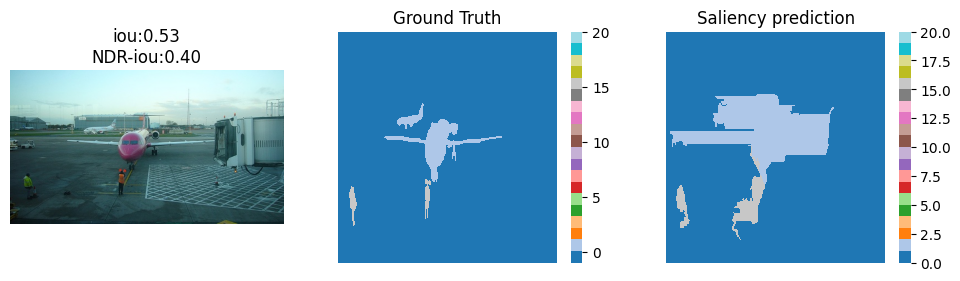

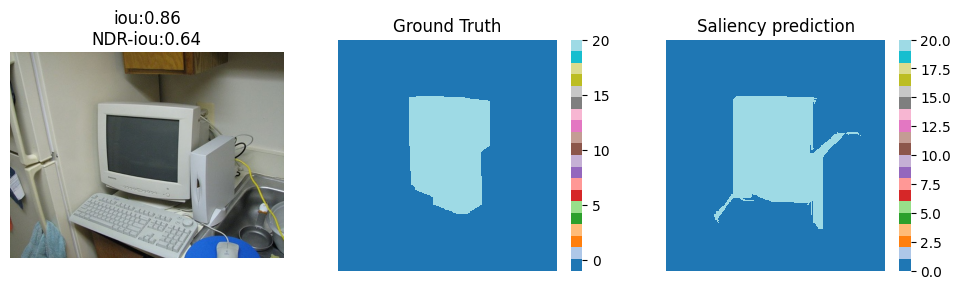

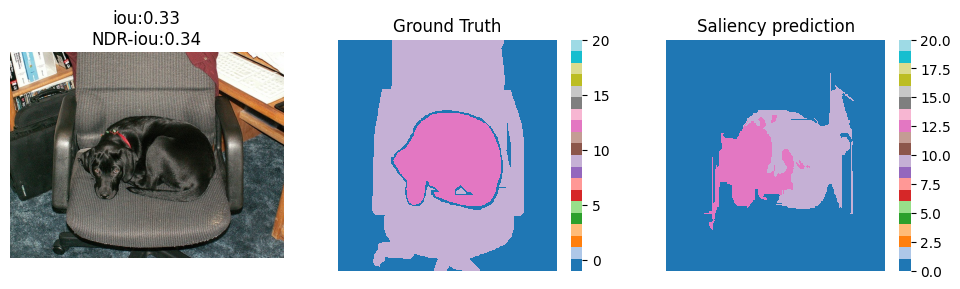

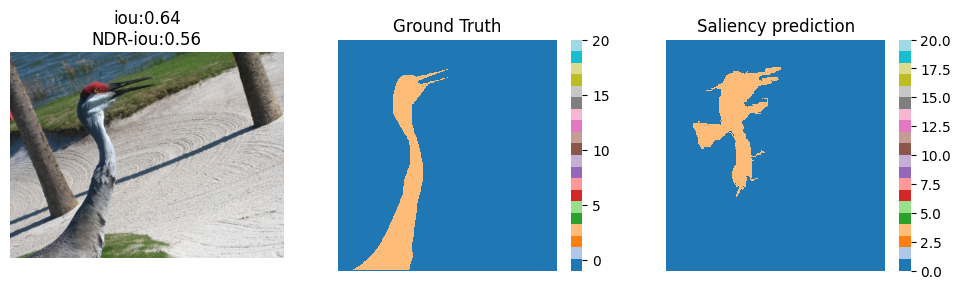

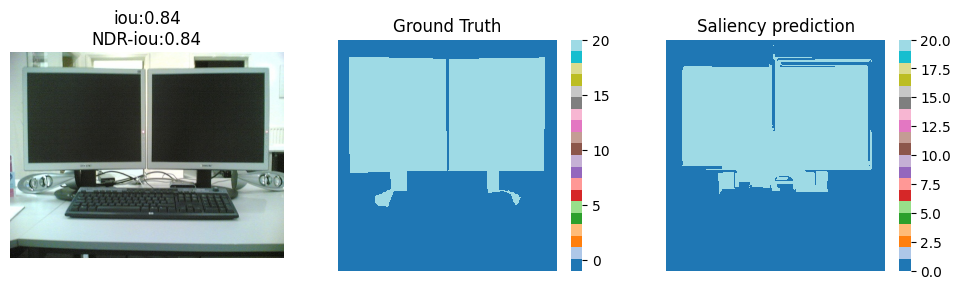

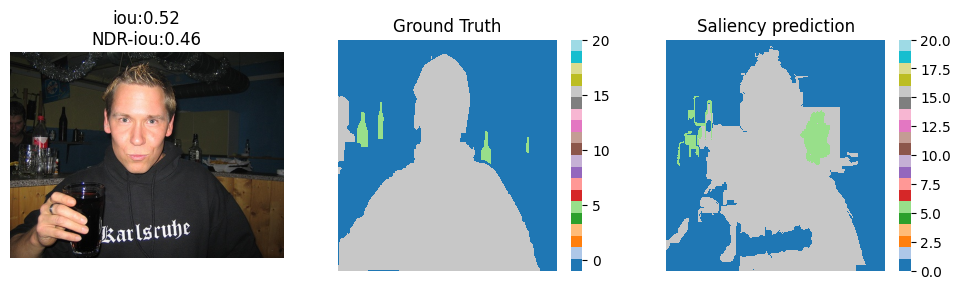

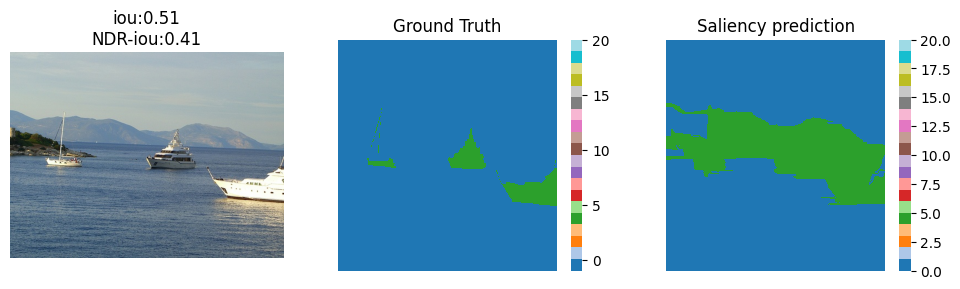

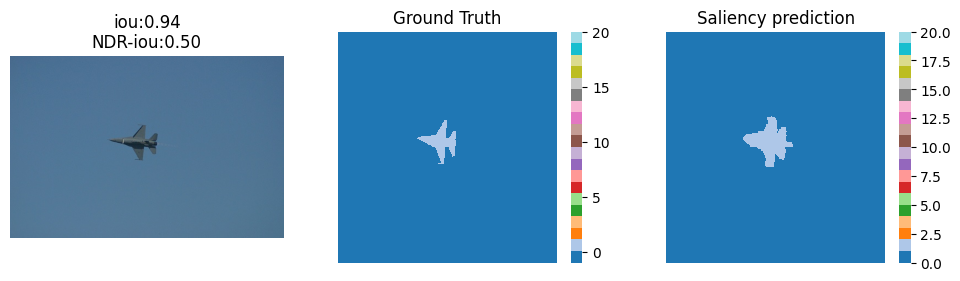

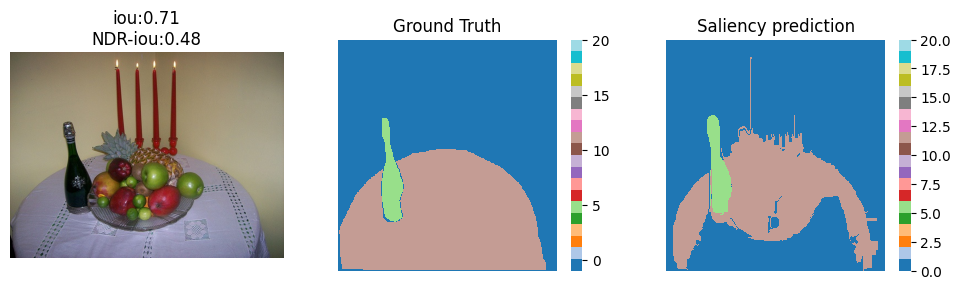

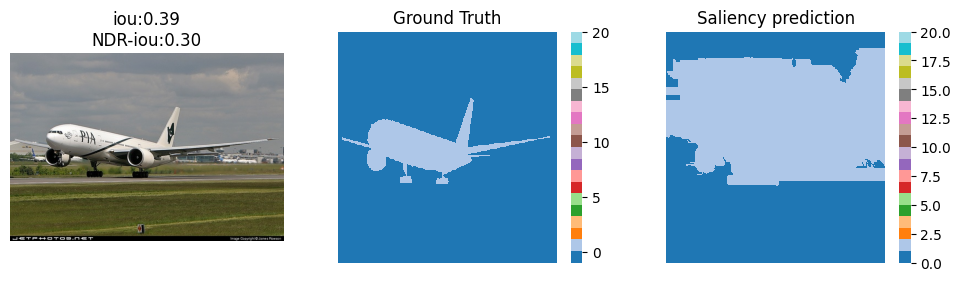

In [19]:
options = {
    'smoothing': True,
    'superpixel': True,
}

viz_first_n_saliencies(options, n=10, thres=0.15)

In [31]:
# Ground truths are in gt_labels
# NDR GTs are in ndr_gt_labels

sm_n_sp_n_thresholds = [round(i, 2) for i in np.arange(0.08, 0.35, .02)]

print(f'\n{"".join(["#" for i in range(60)])}')
print('SMOOTHING: False, SUPERPIXEL: False')
print(f'{"".join(["#" for i in range(60)])}\n')

sm_n_sp_n_miou = []
sm_n_sp_n_ndrmiou = []

for thres in sm_n_sp_n_thresholds:
    preds = get_predictions(thres=thres, smoothing=False, superpixel=False)
    miou = compute_miou(preds, gt_labels)
    sm_n_sp_n_miou.append(miou)
    ndr_miou = compute_miou(preds, ndr_gt_labels)
    sm_n_sp_n_ndrmiou.append(ndr_miou)
    print(f'\nmIoU for {thres}: {miou}\nNDR-mIoU for {thres}: {ndr_miou}\n\n')


############################################################
SMOOTHING: False, SUPERPIXEL: False
############################################################



100%|██████████| 1464/1464 [00:49<00:00, 29.65it/s]



mIoU for 0.08: 0.4223828348753495
NDR-mIoU for 0.08: 0.4195062864579339




100%|██████████| 1464/1464 [00:48<00:00, 30.31it/s]



mIoU for 0.1: 0.40963999784011257
NDR-mIoU for 0.1: 0.3735662548355131




100%|██████████| 1464/1464 [00:49<00:00, 29.84it/s]



mIoU for 0.12: 0.3938775824076493
NDR-mIoU for 0.12: 0.33364840543317487




100%|██████████| 1464/1464 [00:48<00:00, 30.18it/s]



mIoU for 0.14: 0.37631199392091463
NDR-mIoU for 0.14: 0.2987600602645462




100%|██████████| 1464/1464 [00:47<00:00, 30.54it/s]



mIoU for 0.16: 0.3578891682766559
NDR-mIoU for 0.16: 0.26807219424662854




100%|██████████| 1464/1464 [00:47<00:00, 30.57it/s]



mIoU for 0.18: 0.3391853988635501
NDR-mIoU for 0.18: 0.241007904529708




100%|██████████| 1464/1464 [00:48<00:00, 30.49it/s]



mIoU for 0.2: 0.320596849523621
NDR-mIoU for 0.2: 0.2169872991284651




100%|██████████| 1464/1464 [00:48<00:00, 29.99it/s]



mIoU for 0.22: 0.30242033361534104
NDR-mIoU for 0.22: 0.19568938758626395




100%|██████████| 1464/1464 [00:48<00:00, 30.40it/s]



mIoU for 0.24: 0.2848618766719329
NDR-mIoU for 0.24: 0.1767090112286948




100%|██████████| 1464/1464 [00:48<00:00, 30.29it/s]



mIoU for 0.26: 0.26802333799184686
NDR-mIoU for 0.26: 0.15975945789371954




100%|██████████| 1464/1464 [00:47<00:00, 30.76it/s]



mIoU for 0.28: 0.25205959165506886
NDR-mIoU for 0.28: 0.1446476087934986




100%|██████████| 1464/1464 [00:46<00:00, 31.34it/s]



mIoU for 0.3: 0.2369931941921288
NDR-mIoU for 0.3: 0.13115293907854367




100%|██████████| 1464/1464 [00:47<00:00, 30.56it/s]



mIoU for 0.32: 0.22280615420515495
NDR-mIoU for 0.32: 0.11907921284329102




100%|██████████| 1464/1464 [00:49<00:00, 29.86it/s]



mIoU for 0.34: 0.20954572043408426
NDR-mIoU for 0.34: 0.10825096866648269




In [32]:
print(f'Max miou={max(sm_n_sp_n_miou)}, Max ndr-miou={max(sm_n_sp_n_ndrmiou)}')

Max miou=0.4223828348753495, Max ndr-miou=0.4195062864579339


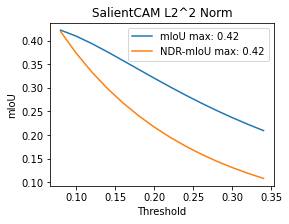

In [33]:
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(sm_n_sp_n_thresholds, sm_n_sp_n_miou, label='mIoU max: {:.2f}'.format(max(sm_n_sp_n_miou)))
plt.plot(sm_n_sp_n_thresholds, sm_n_sp_n_ndrmiou, label='NDR-mIoU max: {:.2f}'.format(max(sm_n_sp_n_ndrmiou)))
plt.xlabel('Threshold')
plt.ylabel('mIoU')
plt.legend()
plt.title('SalientCAM L2^2 Norm')
plt.savefig('mIOU_plt.png')
plt.show()

In [34]:
# Ground truths are in gt_labels
# NDR GTs are in ndr_gt_labels

sm_p_sp_n_thresholds = [round(i, 2) for i in np.arange(0.08, 0.35, .02)]

print(f'\n{"".join(["#" for i in range(60)])}')
print('SMOOTHING: True, SUPERPIXEL: False')
print(f'{"".join(["#" for i in range(60)])}\n')

sm_p_sp_n_miou = []
sm_p_sp_n_ndrmiou = []

for thres in sm_p_sp_n_thresholds:
    preds = get_predictions(thres=thres, smoothing=True, superpixel=False)
    miou = compute_miou(preds, gt_labels)
    sm_p_sp_n_miou.append(miou)
    ndr_miou = compute_miou(preds, ndr_gt_labels)
    sm_p_sp_n_ndrmiou.append(ndr_miou)
    print(f'\nmIoU for {thres}: {miou}\nNDR-mIoU for {thres}: {ndr_miou}\n\n')


############################################################
SMOOTHING: True, SUPERPIXEL: False
############################################################



100%|██████████| 1464/1464 [01:30<00:00, 16.14it/s]



mIoU for 0.08: 0.4427645931945739
NDR-mIoU for 0.08: 0.5086840458918228




100%|██████████| 1464/1464 [01:31<00:00, 16.07it/s]



mIoU for 0.1: 0.44274627262675864
NDR-mIoU for 0.1: 0.47042630952954767




100%|██████████| 1464/1464 [01:32<00:00, 15.90it/s]



mIoU for 0.12: 0.4391030968353438
NDR-mIoU for 0.12: 0.4353201751668044




100%|██████████| 1464/1464 [01:31<00:00, 16.00it/s]



mIoU for 0.14: 0.43276918234561146
NDR-mIoU for 0.14: 0.40285993826134825




100%|██████████| 1464/1464 [01:31<00:00, 15.95it/s]



mIoU for 0.16: 0.42458983684465335
NDR-mIoU for 0.16: 0.3731495257358617




100%|██████████| 1464/1464 [01:32<00:00, 15.78it/s]



mIoU for 0.18: 0.41474686753089285
NDR-mIoU for 0.18: 0.34531917865597




100%|██████████| 1464/1464 [01:35<00:00, 15.38it/s]



mIoU for 0.2: 0.4037004135922901
NDR-mIoU for 0.2: 0.31949229996187856




100%|██████████| 1464/1464 [02:35<00:00,  9.41it/s]



mIoU for 0.22: 0.3917396079669436
NDR-mIoU for 0.22: 0.2957315774181035




100%|██████████| 1464/1464 [02:32<00:00,  9.57it/s]



mIoU for 0.24: 0.37902703812139343
NDR-mIoU for 0.24: 0.27374747026395496




100%|██████████| 1464/1464 [02:30<00:00,  9.73it/s]



mIoU for 0.26: 0.36566588856348753
NDR-mIoU for 0.26: 0.25333641792635114




100%|██████████| 1464/1464 [02:31<00:00,  9.64it/s]



mIoU for 0.28: 0.35193208291787575
NDR-mIoU for 0.28: 0.23442482682825386




100%|██████████| 1464/1464 [02:31<00:00,  9.65it/s]



mIoU for 0.3: 0.3379222689927626
NDR-mIoU for 0.3: 0.21678362252563094




100%|██████████| 1464/1464 [02:31<00:00,  9.68it/s]



mIoU for 0.32: 0.32379687462417717
NDR-mIoU for 0.32: 0.20017929428560186




100%|██████████| 1464/1464 [02:30<00:00,  9.72it/s]



mIoU for 0.34: 0.3096925107144597
NDR-mIoU for 0.34: 0.18467543352948848




In [35]:
print(f'Max miou={max(sm_p_sp_n_miou)}, Max ndr-miou={max(sm_p_sp_n_ndrmiou)}')

Max miou=0.4427645931945739, Max ndr-miou=0.5086840458918228


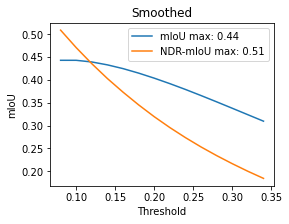

In [36]:
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(sm_p_sp_n_thresholds, sm_p_sp_n_miou, label='mIoU max: {:.2f}'.format(max(sm_p_sp_n_miou)))
plt.plot(sm_p_sp_n_thresholds, sm_p_sp_n_ndrmiou, label='NDR-mIoU max: {:.2f}'.format(max(sm_p_sp_n_ndrmiou)))
plt.xlabel('Threshold')
plt.ylabel('mIoU')
plt.legend()
plt.title('Smoothed')
plt.savefig('mIOU_plt_1.png')
plt.show()

In [37]:
# Ground truths are in gt_labels
# NDR GTs are in ndr_gt_labels

sm_p_sp_p_thresholds = [round(i, 2) for i in np.arange(0.10, 0.30, .02)]

print(f'\n{"".join(["#" for i in range(60)])}')
print('SMOOTHING: True, SUPERPIXEL: True')
print(f'{"".join(["#" for i in range(60)])}\n')

sm_p_sp_p_miou = []
sm_p_sp_p_ndrmiou = []

for thres in sm_p_sp_p_thresholds:
    preds = get_predictions(thres=thres, smoothing=True, superpixel=True)
    miou = compute_miou(preds, gt_labels)
    sm_p_sp_p_miou.append(miou)
    ndr_miou = compute_miou(preds, ndr_gt_labels)
    sm_p_sp_p_ndrmiou.append(ndr_miou)
    print(f'\nmIoU for {thres}: {miou}\nNDR-mIoU for {thres}: {ndr_miou}\n\n')


############################################################
SMOOTHING: True, SUPERPIXEL: True
############################################################



100%|██████████| 1464/1464 [06:22<00:00,  3.82it/s]



mIoU for 0.1: 0.48837758042754165
NDR-mIoU for 0.1: 0.585023076398181




100%|██████████| 1464/1464 [06:21<00:00,  3.84it/s]



mIoU for 0.12: 0.4890403588487851
NDR-mIoU for 0.12: 0.536685194383777




100%|██████████| 1464/1464 [06:18<00:00,  3.87it/s]



mIoU for 0.14: 0.48251584380837576
NDR-mIoU for 0.14: 0.49646168419686715




100%|██████████| 1464/1464 [06:15<00:00,  3.90it/s]



mIoU for 0.16: 0.47561866505268957
NDR-mIoU for 0.16: 0.46384770269729136




100%|██████████| 1464/1464 [06:13<00:00,  3.92it/s]



mIoU for 0.18: 0.4623475776268795
NDR-mIoU for 0.18: 0.42731659544590594




100%|██████████| 1464/1464 [06:09<00:00,  3.96it/s]



mIoU for 0.2: 0.44693645556501366
NDR-mIoU for 0.2: 0.3892273919507891




100%|██████████| 1464/1464 [06:30<00:00,  3.75it/s]



mIoU for 0.22: 0.4346230720339716
NDR-mIoU for 0.22: 0.36290111728662217




100%|██████████| 1464/1464 [06:26<00:00,  3.79it/s]



mIoU for 0.24: 0.41622933068968043
NDR-mIoU for 0.24: 0.33013384312132826




100%|██████████| 1464/1464 [06:31<00:00,  3.74it/s]



mIoU for 0.26: 0.39643791412843354
NDR-mIoU for 0.26: 0.29859891636196684




100%|██████████| 1464/1464 [06:25<00:00,  3.80it/s]



mIoU for 0.28: 0.3758157676107213
NDR-mIoU for 0.28: 0.26720779641124653




In [38]:
print(f'Max miou={max(sm_p_sp_p_miou)}, Max ndr-miou={max(sm_p_sp_p_ndrmiou)}')

Max miou=0.4890403588487851, Max ndr-miou=0.585023076398181


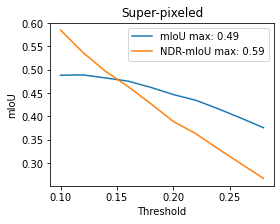

In [39]:
fig, ax = plt.subplots(figsize=(4, 3))
plt.plot(sm_p_sp_p_thresholds, sm_p_sp_p_miou, label='mIoU max: {:.2f}'.format(max(sm_p_sp_p_miou)))
plt.plot(sm_p_sp_p_thresholds, sm_p_sp_p_ndrmiou, label='NDR-mIoU max: {:.2f}'.format(max(sm_p_sp_p_ndrmiou)))
plt.xlabel('Threshold')
plt.ylabel('mIoU')
plt.legend()
plt.title('Super-pixeled')
plt.savefig('mIOU_plt_2.png')
plt.show()

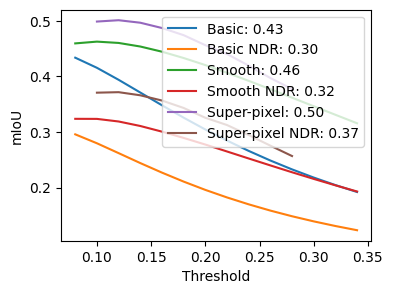

In [34]:
# all together
fig, ax = plt.subplots(figsize=(4, 3))

plt.plot(sm_n_sp_n_thresholds, sm_n_sp_n_miou, label='Basic: {:.2f}'.format(max(sm_n_sp_n_miou)))
plt.plot(sm_n_sp_n_thresholds, sm_n_sp_n_ndrmiou, label='Basic NDR: {:.2f}'.format(max(sm_n_sp_n_ndrmiou)))

plt.plot(sm_p_sp_n_thresholds, sm_p_sp_n_miou, label='Smooth: {:.2f}'.format(max(sm_p_sp_n_miou)))
plt.plot(sm_p_sp_n_thresholds, sm_p_sp_n_ndrmiou, label='Smooth NDR: {:.2f}'.format(max(sm_p_sp_n_ndrmiou)))

plt.plot(sm_p_sp_p_thresholds, sm_p_sp_p_miou, label='Super-pixel: {:.2f}'.format(max(sm_p_sp_p_miou)))
plt.plot(sm_p_sp_p_thresholds, sm_p_sp_p_ndrmiou, label='Super-pixel NDR: {:.2f}'.format(max(sm_p_sp_p_ndrmiou)))

plt.xlabel('Threshold')
plt.ylabel('mIoU')
plt.legend()

plt.show()

###### Create folders for saliencies

In [30]:
# ! mkdir -p /raid/maruf/WSS/SALIENCY/original/image/
# ! mkdir -p /raid/maruf/WSS/SALIENCY/original/image_crop/
# ! mkdir -p /raid/maruf/WSS/SALIENCY/original/image_binmask/
# ! mkdir -p /raid/maruf/WSS/SALIENCY/original/image_binmask_crop/
# ! ls /raid/maruf/WSS/SALIENCY/original/